In [1]:
import gevfit
import analysis
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.axes as axes

### Experiments 22, 23, 24, 26: Cori on 512 Ranks

#### Contains 4 Runs of Each (for a total of 16):
- DGemm: a=256, b=64, 500 iterations, no interference
- DGemm: a=256, b=64, 500 iterations, stencil size 32768
- DGemm: a=256, b=64, 500 iterations, rabbit workload
- DGemm: a=256, b=64, 500 iterations, both stencil and rabbit workload

In [2]:
# Get DataFrame of All Experiments
df_All = analysis.getAllExperiments()

# Get only Cori 512 Rank data
df_Cori512 = df_All[(df_All['Experiment'] == 22) | (df_All['Experiment'] == 23) | (df_All['Experiment'] == 24) | (df_All['Experiment'] == 26)]

In [3]:
# Get Runs on Cori with 512 Ranks  
df_Cori512_NoInterference = df_Cori512[(df_Cori512['workload'] == 'dgemm') & (df_Cori512['stencil_size'] == 0) & (df_Cori512['rabbit'] == 0) & (df_Cori512['rabbit_workload'] == 0) & (df_Cori512['osu'] == 0)]
df_Cori512_Interference = df_Cori512[(df_Cori512['workload'] == 'dgemm') & (df_Cori512['stencil_size'] ==32768) & (df_Cori512['rabbit'] == 0) & (df_Cori512['rabbit_workload'] == 1) & (df_Cori512['osu'] == 0)]
df_Cori512_Stencil_NoInterference = df_Cori512[(df_Cori512['workload'] == 'dgemm') & (df_Cori512['stencil_size'] ==32768) & (df_Cori512['rabbit'] == 0) & (df_Cori512['rabbit_workload'] == 0) & (df_Cori512['osu'] == 0)]
df_Cori512_Interference_NoStencil = df_Cori512[(df_Cori512['workload'] == 'dgemm') & (df_Cori512['stencil_size'] ==0) & (df_Cori512['rabbit'] == 0) & (df_Cori512['rabbit_workload'] == 1) & (df_Cori512['osu'] == 0)]
df_Cori512_exp22=df_All[df_All['Experiment'] == 22]
df_Cori512_exp23=df_All[df_All['Experiment'] == 23]
df_Cori512_exp24=df_All[df_All['Experiment'] == 24]
df_Cori512_exp26=df_All[df_All['Experiment'] == 26]

Cori 512 Ranks - No Interference
Runtime: 379965983.689 Shape: 0.3038728669612235 Loc: 759253.5443383269 Scale: 1999.3718092727895
Runtime: 406012167.36 Shape: 0.3771460082665638 Loc: 811409.0468135858 Scale: 2085.856874858468
Runtime: 401474186.38199997 Shape: 0.48822069469764434 Loc: 802203.2559061822 Scale: 3188.3731956794445
Runtime: 406908715.663 Shape: -0.05189019040657057 Loc: 813166.9791270139 Scale: 1030.6215809702144
Cori 512 Ranks - Stencil
Runtime: 379757025.05799997 Shape: 0.4955837354981945 Loc: 758962.7123248548 Scale: 2398.7300807259594
Runtime: 407535155.97099996 Shape: -0.10926076840288729 Loc: 814498.973796247 Scale: 819.0618213330345
Runtime: 401514764.264 Shape: -0.2816801882610009 Loc: 800945.6487297564 Scale: 2174.346985008522
Runtime: 407135011.20500004 Shape: 0.3933636951982385 Loc: 813918.5288358553 Scale: 1230.6112286921673
Cori 512 Ranks - Stencil and Rabbit
Runtime: 376476933.125 Shape: -0.2260619303985136 Loc: 751766.6863472885 Scale: 1377.4885597013508
Ru

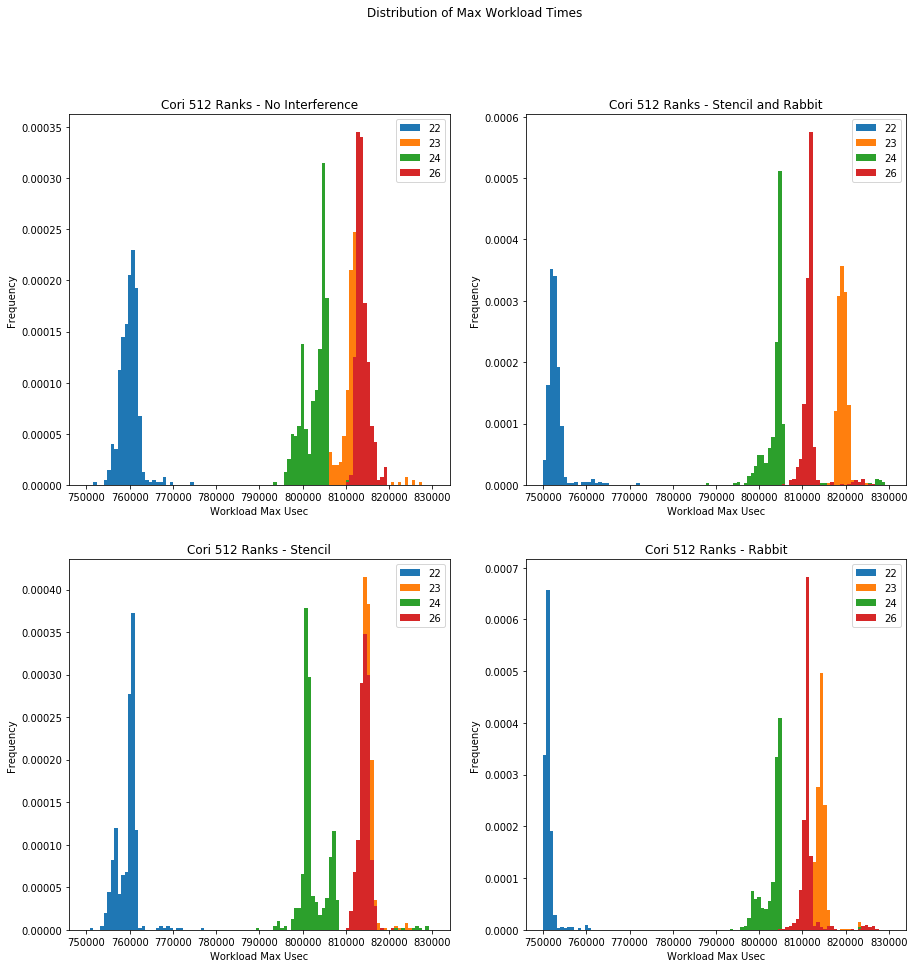

In [4]:
# Loop over all 4 runs of each type and get data.
# Since data is verbose, only get rank 0 data

# For each Set of 4 Runs (No Interference, Stencil, Rabbit, Stencil + Rabbit)
# Calculate runtime and add to runtime list
# Get GEV parameters and add to shape, loc, and scale lists
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Distribution of Max Workload Times')

count = 0
for df in [df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference, df_Cori512_Interference_NoStencil]:
    i = count % 2
    j = (int) (count / 2)
    if count == 0:
        title = "Cori 512 Ranks - No Interference"
    elif count == 1:
        title = "Cori 512 Ranks - Stencil"
    elif count == 2:
        title = "Cori 512 Ranks - Stencil and Rabbit"
    elif count == 3:
        title = "Cori 512 Ranks - Rabbit"
    
    print(title)
    
    runTimes = []
    shapeList = []
    locList = []
    scaleList = []

    for run in range(0, len(df)):
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'

        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        shape, loc, scale = gevfit.fit(currentData['interval_max_usec'])

        print("Runtime:", currentRunTime, "Shape:", shape, "Loc:", loc, "Scale:", scale)
        # print(gevfit.fit_ci(currentData['interval_max_usec']))

        runTimes.append(currentRunTime)
        shapeList.append(shape)
        locList.append(loc)
        scaleList.append(scale)

        bins = range(750000, 2000, 830000)
        _ = axs[i][j].hist(currentData['workload_max_usec'], density=True, label=currentRun['Experiment'], range=[750000, 830000], bins=100)
    _ = axs[i][j].set_title(title)
    _ = axs[i][j].set_xlabel('Workload Max Usec')
    _ = axs[i][j].set_ylabel('Frequency')
    _ = axs[i][j].legend()
    count = count + 1
    


### Emma Projections for 512 Rank Cori Data
#### Projected the total runtime from the k = 1 case (512 Ranks) with k = 2, 4, 8, 16

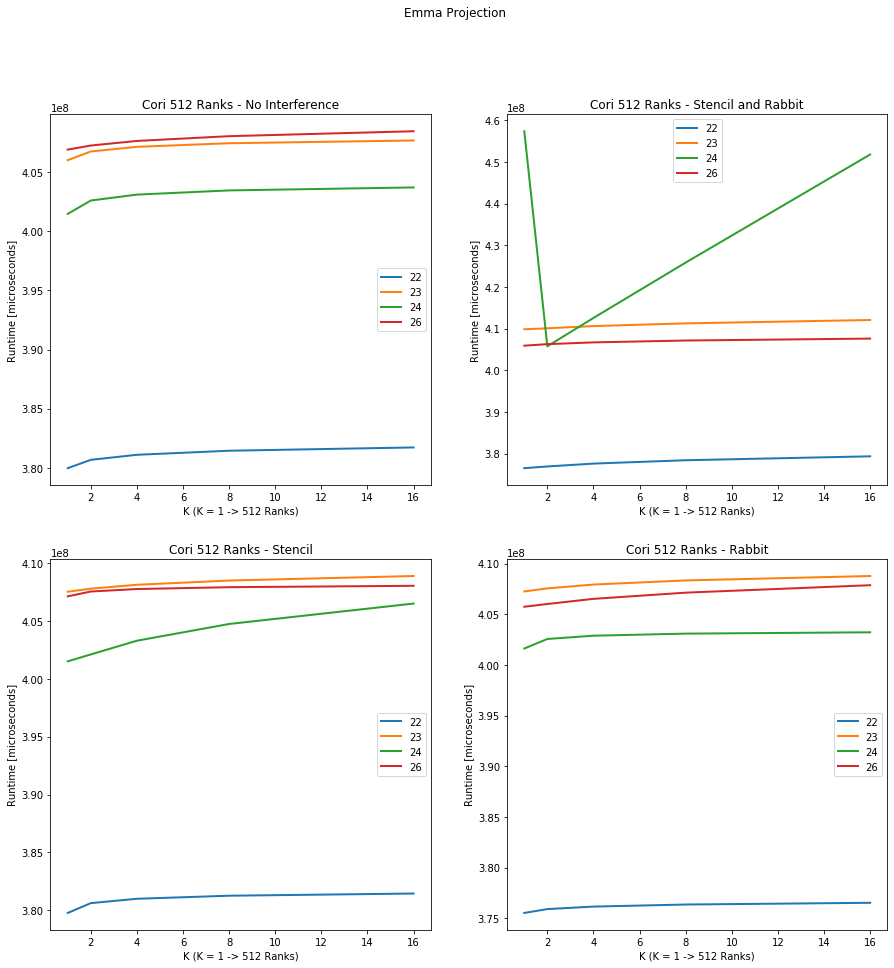

In [5]:
## Emma Projection Method with different k values
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Emma Projection')

count = 0
for df in [df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference, df_Cori512_Interference_NoStencil]:
    i = count % 2
    j = (int) (count / 2)
    if count == 0:
        title = "Cori 512 Ranks - No Interference"
    elif count == 1:
        title = "Cori 512 Ranks - Stencil"
    elif count == 2:
        title = "Cori 512 Ranks - Stencil and Rabbit"
    elif count == 3:
        title = "Cori 512 Ranks - Rabbit"
    
    # print(title)
    
    runTimes=[]
    for run in range(0, len(df)):
        data=[]
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentRun = df_Cori512_NoInterference.iloc[run]
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        runTimes.append(currentRunTime)
        shape, loc, scale = gevfit.fit(currentData['workload_max_usec'])
        dist = stats.genextreme(shape, loc, scale)
        iteration=int(pd.DataFrame(df['iterations']).iloc[0])
        data.append(currentRunTime)

        for k in [2,4,8,16]:
            emmaprojectedData = analysis.emma(dist,k) * iteration
            data.append(emmaprojectedData)

        axs[i][j].plot([1,2,4,8,16], data, label=str(eid), linewidth=2)

    axs[i][j].set_xlabel('K (K = 1 -> 512 Ranks)')
    axs[i][j].set_ylabel('Runtime [microseconds]')
    axs[i][j].set_title(title)
    axs[i][j].legend()
    count = count + 1

### Resample Projection Method for Cori Data
#### Projected the total runtime from the k = 1 case (512 Ranks) with k = 2, 4, 8, 16

380574063.3219998
380980704.7730004
381495615.0040004
381849243.76599985
406456049.902
407108579.54500014
407493116.849
408391841.6830007
402170404.9419999
402933417.24700004
403371862.7520002
404159818.8900003
407223946.9180003
407674486.3920001
408055272.3550004
408455609.4099996
380400220.5999997
380792335.68800044
381295480.7930002
381935577.33900017
407915174.6909998
408283044.7049997
408726697.59999967
409472308.1509991
402478639.9760001
403848756.78399974
405811195.2529996
407192504.7489993
407471552.31799954
407702369.74000037
407906211.42500013
408156750.0639998
376942087.8639999
377461492.83899957
378546877.4079991
381423659.352999
410281246.30200016
410999071.8689997
411767548.97699934
412850563.8769999
613110606.3610002
716795115.8999996
978066024.1739997
1305402382.3070004
406361981.8400005
406653315.11700034
407433886.19299984
408312326.07599944
375837328.2950003
376070540.7239998
376391949.17199993
376897159.0680003
407590656.39399964
408057176.3599996
408438295.9639996


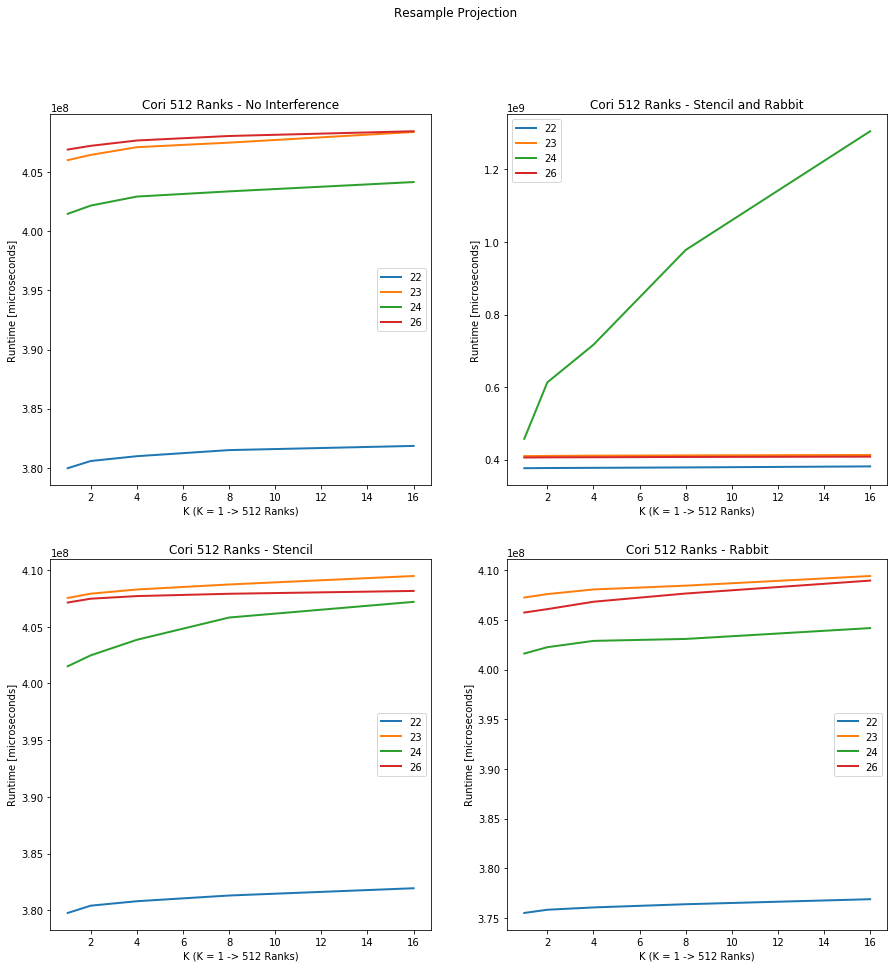

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Resample Projection')

count = 0
for df in [df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference, df_Cori512_Interference_NoStencil]:
    i = count % 2
    j = (int) (count / 2)
    if count == 0:
        title = "Cori 512 Ranks - No Interference"
    elif count == 1:
        title = "Cori 512 Ranks - Stencil"
    elif count == 2:
        title = "Cori 512 Ranks - Stencil and Rabbit"
    elif count == 3:
        title = "Cori 512 Ranks - Rabbit"
    
    # print(title)
    
    ## Resample Projection Method with different k values 
    for run in range(0, len(df)):
        data=[]
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        data.append(currentRunTime)
        for k in [2,4,8,16]:
            resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
            projectedRunTime = sum(resampleprojectedData)
            print(projectedRunTime)
            data.append(projectedRunTime)
        axs[i][j].plot([1,2,4,8,16],data,label=str(eid), linewidth=2)

    axs[i][j].set_xlabel('K (K = 1 -> 512 Ranks)')
    axs[i][j].set_ylabel('Runtime [microseconds]')
    axs[i][j].set_title(title)
    axs[i][j].legend()
    count = count + 1

### Block Projection Method for Cori Data
#### Projected the total runtime from the k = 1 case (512 Ranks) with k = 2, 4, 8, 16

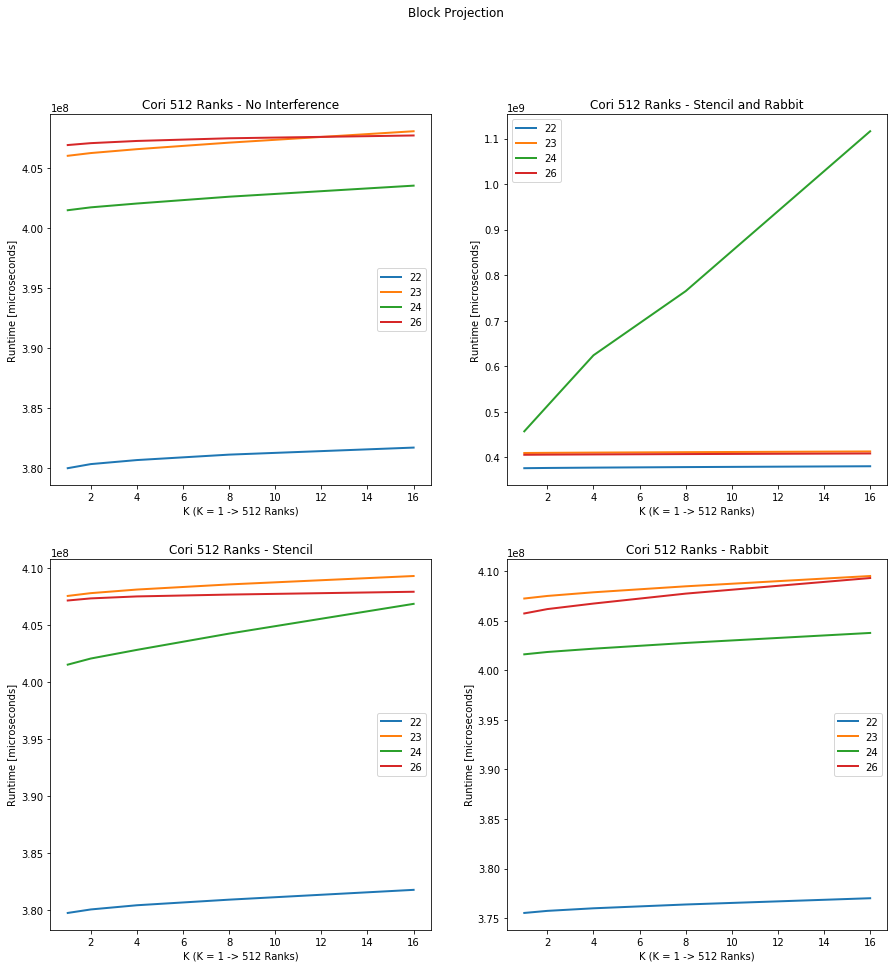

In [7]:
## Block Projection Method with different k values 
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Block Projection')

count = 0
for df in [df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference, df_Cori512_Interference_NoStencil]:
    i = count % 2
    j = (int) (count / 2)
    if count == 0:
        title = "Cori 512 Ranks - No Interference"
    elif count == 1:
        title = "Cori 512 Ranks - Stencil"
    elif count == 2:
        title = "Cori 512 Ranks - Stencil and Rabbit"
    elif count == 3:
        title = "Cori 512 Ranks - Rabbit"
    
    # print(title)
    
    for run in range(0, len(df)):
        data=[]
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        data.append(currentRunTime)
        for k in [2,4,8,16]:
            blockprojectedData=analysis.block_maxima_project(currentRun, len(currentData), k, col='workload_max_usec')
            projectedRunTime = sum(blockprojectedData) * (len(currentData) / len(blockprojectedData))
            # print(projectedRunTime)
            data.append(projectedRunTime)
        axs[i][j].plot([1,2,4,8,16],data,label=str(eid), linewidth=2)

    axs[i][j].set_xlabel('K (K = 1 -> 512 Ranks)')
    axs[i][j].set_ylabel('Runtime [microseconds]')
    axs[i][j].set_title(title)
    axs[i][j].legend()
    
    count = count + 1

### Block Maxima Projection for Cori Data Continued (Only No Interference)
#### 512 Ranks with No Interference 
- Compare Histogram of Experiment 19 on 1024 Ranks with Histogram of Experiments 22 and 26 (Original on 512 Ranks) Scaled up with Block Maxima k = 2 (Prediction of Distribution on 1024 Ranks)

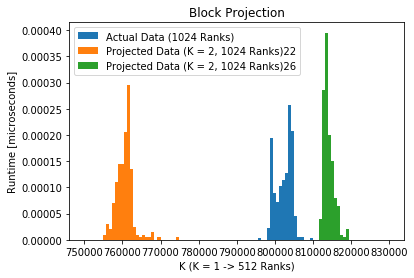

In [8]:
## Block Projected data vs actual data
k=2

df_Cori_2 = df_All[(df_All['Experiment'] == 22) | (df_All['Experiment'] == 19) | (df_All['Experiment'] == 26) ]
df_Cori_NoInterference_2 = df_Cori_2[(df_Cori_2['workload'] == 'dgemm') & (df_Cori_2['stencil_size'] == 0) & (df_Cori_2['rabbit'] == 0) & (df_Cori_2['rabbit_workload'] == 0) & (df_Cori_2['osu'] == 0)]

for run in range(0, len(df_Cori_NoInterference_2)):
    currentRun = df_Cori_NoInterference_2.iloc[run]
    eid = currentRun['Experiment']
    rid = currentRun['expid']       
    currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
    currentData = analysis.getData(currentPath)
    currentData = currentData[currentData['rank'] == 0]
    if eid==22 or eid==26:
        blockprojectedData = analysis.block_maxima_project(currentRun, len(currentData), k, col='workload_max_usec')
          
        plt.hist(blockprojectedData, density=True, label='Projected Data (K = 2, 1024 Ranks)' + str(eid), range=[750000, 830000], bins=100)
    if eid==19:
        plt.hist(currentData['workload_max_usec'], density=True, label='Actual Data (1024 Ranks)', range=[750000, 830000], bins=100)

        plt.xlabel('K (K = 1 -> 512 Ranks)')
plt.ylabel('Runtime [microseconds]')
plt.title('Block Projection')    
plt.legend()

### Finding the ranks corresponding to the workload_max_usec

In [9]:
count = 0
#ndlist=[]
for df in [df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference, df_Cori512_Interference_NoStencil]:
    i = count % 2
    j = (int) (count / 2)
    if count == 0:
        title = "Cori 512 Ranks - No Interference"
    elif count == 1:
        title = "Cori 512 Ranks - Stencil"
    elif count == 2:
        title = "Cori 512 Ranks - Stencil and Rabbit"
    elif count == 3:
        title = "Cori 512 Ranks - Rabbit"
    
    print(title)
    
    for run in range(0, len(df)):
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)

        countData = currentData[currentData['workload_usec'] == currentData['workload_max_usec']].groupby('rank',as_index=False).count()
        rankList = countData['rank'].tolist()
        nodelist=currentData[(currentData['rank'].isin(rankList))]['node'].unique()
        #ndlist.append(nodelist)
        print(rankList, nodelist)
        print("Experiment:", eid)
        print("Contributions by Rank:", end="\t")
        for item in range(0, len(countData)):
            data = countData.iloc[item]
            print(data['uniq_id'], end="\t")
            #print(data['node'],end="\t")
        print()
    count = count + 1
    print()
    


Cori 512 Ranks - No Interference
[1, 256, 270, 302] ['nid12697' 'nid12705' 'nid12706']
Experiment: 22
Contributions by Rank:	1	2	10	487	
[52, 58, 407] ['nid02004' 'nid01799']
Experiment: 23
Contributions by Rank:	197	12	291	
[169, 201, 236, 246, 358] ['nid01676' 'nid01677' 'nid01678' 'nid01889']
Experiment: 24
Contributions by Rank:	416	70	1	12	1	
[208, 216] ['nid01561']
Experiment: 26
Contributions by Rank:	488	12	

Cori 512 Ranks - Stencil
[93, 136, 222, 274, 280, 290, 407, 423, 494] ['nid12701' 'nid12703' 'nid12705' 'nid12706' 'nid12709' 'nid12710'
 'nid12712' 'nid12699']
Experiment: 22
Contributions by Rank:	1	1	5	338	7	44	91	12	1	
[22, 24, 40, 377, 393] ['nid01798' 'nid02003' 'nid02004' 'nid01799']
Experiment: 23
Contributions by Rank:	1	8	4	245	242	
[189, 205, 212, 220, 228, 236, 411] ['nid01676' 'nid01677' 'nid01678' 'nid01890']
Experiment: 24
Contributions by Rank:	316	129	17	32	1	4	1	
[184, 190, 200, 206, 214, 230] ['nid01560' 'nid01561' 'nid01562']
Experiment: 26
Contribution

### Comparing rank 1 with rank 302 of No Interference Data, Experiment 22

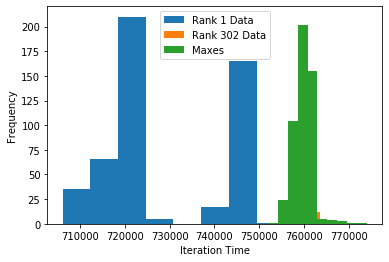

In [10]:
currentRun = df_Cori512_NoInterference.iloc[0]
eid = currentRun['Experiment']
rid = currentRun['expid']
currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
currentData = analysis.getData(currentPath)

Data1 = currentData[currentData['rank'] == 1]['workload_usec']
Data302 = currentData[currentData['rank'] == 302]['workload_usec']
DataMax = currentData[currentData['rank'] == 0]['workload_max_usec']

_ = plt.hist(Data1, label='Rank 1 Data')
_ = plt.hist(Data302, label='Rank 302 Data')
_ = plt.hist(DataMax, label='Maxes')
_ = plt.legend()
_ = plt.xlabel('Iteration Time')
_ = plt.ylabel('Frequency')

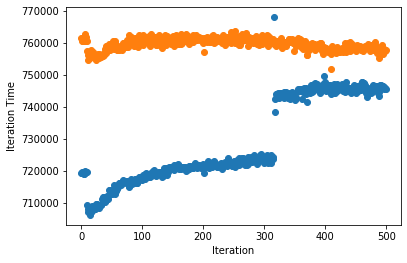

In [11]:
_ = plt.plot(range(0, 500), Data1, 'o', label='Rank 1')
_ = plt.plot(range(0, 500), Data302, 'o', label='Rank 302')
_ = plt.xlabel('Iteration')
_ = plt.ylabel('Iteration Time')

Text(0.5, 1.08, 'Emma Projection with stencil,no interference')

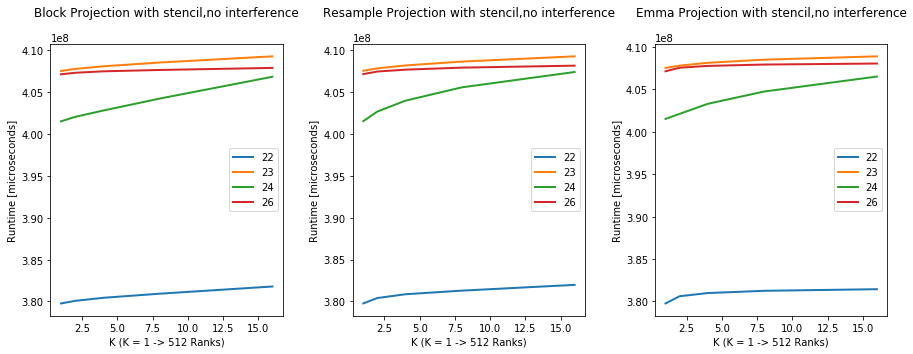

In [12]:
fig,axes=plt.subplots(nrows=1,ncols= 3,figsize=(15,5))
plt.subplots_adjust(wspace = .3,hspace =.3)
#fig.tight_layout()
for run in range(0, len(df_Cori512_Stencil_NoInterference)):
    data_block=[]
    data_resample=[]
    data_emma=[]
    currentRun = df_Cori512_Stencil_NoInterference.iloc[run]
    eid = currentRun['Experiment']
    rid = currentRun['expid']
    currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
    currentData = analysis.getData(currentPath)
    currentData = currentData[currentData['rank'] == 0]
    currentRunTime = currentData['interval_max_usec'].sum()
    data_block.append(currentRunTime)
    data_resample.append(currentRunTime)
    #currentRunTime = currentData['interval_max_usec'].sum()
    #runTimes.append(currentRunTime)
    shape, loc, scale = gevfit.fit(currentData['workload_max_usec'])
    dist = stats.genextreme(shape, loc, scale)
    iteration=int(pd.DataFrame(df_Cori512_Stencil_NoInterference['iterations']).iloc[0])
    data_emma.append(currentRunTime)
    for k in [2,4,8,16]:
        blockprojectedData=analysis.block_maxima_project(currentRun, len(currentData), k, col='workload_max_usec')
        blkprojectedRunTime = sum(blockprojectedData) * (len(currentData) / len(blockprojectedData))
        data_block.append(blkprojectedRunTime)
        
        resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
        resampleprojectedRunTime = sum(resampleprojectedData)
        data_resample.append(resampleprojectedRunTime)
        
        emmaprojectedData = analysis.emma(dist,k)*iteration
        data_emma.append(emmaprojectedData)
    #plt.figure()
    axes[0].plot([1,2,4,8,16],data_block,label=str(eid), linewidth=2)
    #plt.figure()
    axes[1].plot([1,2,4,8,16],data_resample,label=str(eid), linewidth=2)
    
    axes[2].plot([1,2,4,8,16],data_emma,label=str(eid), linewidth=2)
for i in range(3):
    axes[i].set(xlabel='K (K = 1 -> 512 Ranks)', ylabel='Runtime [microseconds]')
    axes[i].legend(['22','23','24','26'])
#plt.xlabel('K (K = 1 -> 512 Ranks)')
#plt.ylabel('Runtime [microseconds]')
axes[0].set_title('Block Projection with stencil,no interference',y=1.08)
axes[1].set_title('Resample Projection with stencil,no interference',y=1.08)
axes[2].set_title('Emma Projection with stencil,no interference',y=1.08)



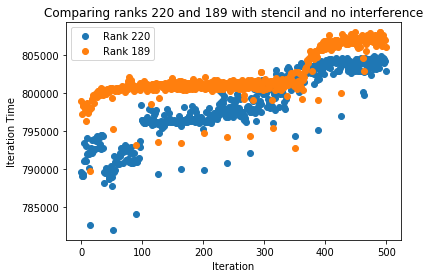

In [13]:
currentRun = df_Cori512_Stencil_NoInterference.iloc[2]
eid = currentRun['Experiment']
rid = currentRun['expid']
currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
currentData = analysis.getData(currentPath)

Data1 = currentData[currentData['rank'] == 220]['workload_usec']
Data302 = currentData[currentData['rank'] == 189]['workload_usec']
DataMax = currentData[currentData['rank'] == 0]['workload_max_usec']
plt.plot(range(0, 500), Data1, 'o', label='Rank 220')
plt.plot(range(0, 500), Data302, 'o', label='Rank 189')
plt.xlabel('Iteration')
plt.ylabel('Iteration Time')
plt.title('Comparing ranks 220 and 189 with stencil and no interference')
plt.legend()

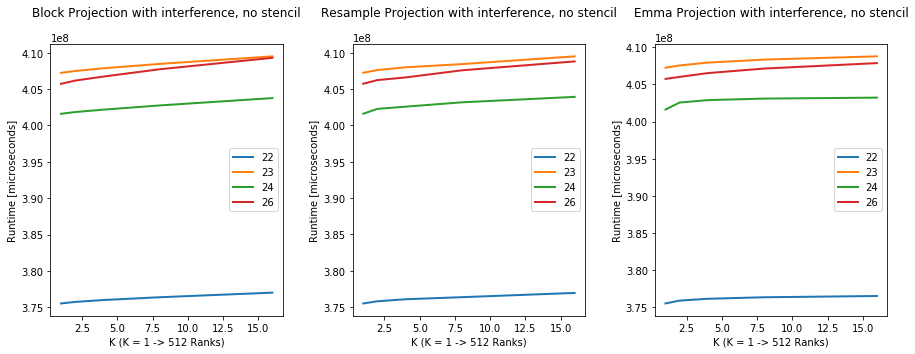

In [14]:
fig,axes=plt.subplots(nrows=1,ncols= 3,figsize=(15,5))
plt.subplots_adjust(wspace = .3,hspace =.3)
#fig.tight_layout()
for run in range(0, len(df_Cori512_Interference_NoStencil)):
    data_block=[]
    data_resample=[]
    data_emma=[]
    currentRun = df_Cori512_Interference_NoStencil.iloc[run]
    eid = currentRun['Experiment']
    rid = currentRun['expid']
    currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
    currentData = analysis.getData(currentPath)
    currentData = currentData[currentData['rank'] == 0]
    currentRunTime = currentData['interval_max_usec'].sum()
    data_block.append(currentRunTime)
    data_resample.append(currentRunTime)
    #currentRunTime = currentData['interval_max_usec'].sum()
    #runTimes.append(currentRunTime)
    shape, loc, scale = gevfit.fit(currentData['workload_max_usec'])
    dist = stats.genextreme(shape, loc, scale)
    iteration=int(pd.DataFrame(df_Cori512_Interference_NoStencil['iterations']).iloc[0])
    data_emma.append(currentRunTime)
    for k in [2,4,8,16]:
        blockprojectedData=analysis.block_maxima_project(currentRun, len(currentData), k, col='workload_max_usec')
        blkprojectedRunTime = sum(blockprojectedData) * (len(currentData) / len(blockprojectedData))
        data_block.append(blkprojectedRunTime)
        
        resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
        resampleprojectedRunTime = sum(resampleprojectedData)
        data_resample.append(resampleprojectedRunTime)
        
        emmaprojectedData = analysis.emma(dist,k)*iteration
        data_emma.append(emmaprojectedData)
        
    _ = axes[0].plot([1,2,4,8,16],data_block,label=str(eid), linewidth=2)
    _ = axes[1].plot([1,2,4,8,16],data_resample,label=str(eid), linewidth=2)
    _ = axes[2].plot([1,2,4,8,16],data_emma,label=str(eid), linewidth=2)
    
for i in range(3):
    _ = axes[i].set(xlabel='K (K = 1 -> 512 Ranks)', ylabel='Runtime [microseconds]')
    _ = axes[i].legend(['22','23','24','26'])

_ = axes[0].set_title('Block Projection with interference, no stencil',y=1.08)
_ = axes[1].set_title('Resample Projection with interference, no stencil',y=1.08)
_ = axes[2].set_title('Emma Projection with interference, no stencil',y=1.08)



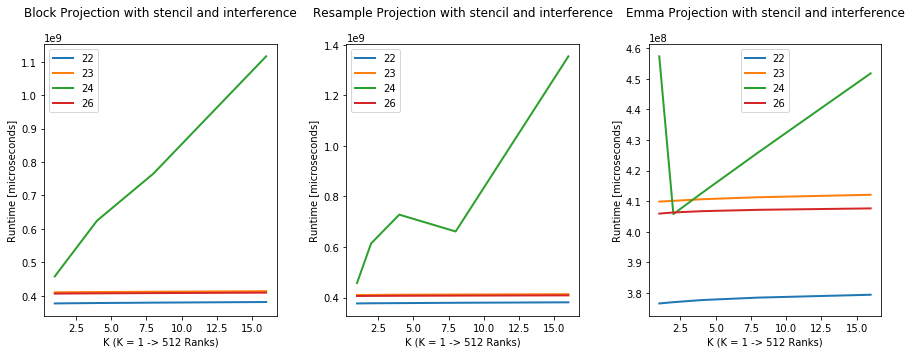

In [15]:
fig,axes=plt.subplots(nrows=1,ncols= 3,figsize=(15,5))
plt.subplots_adjust(wspace = .3,hspace =.3)

for run in range(0, len(df_Cori512_Interference)):
    data_block=[]
    data_resample=[]
    data_emma=[]
    currentRun = df_Cori512_Interference.iloc[run]
    eid = currentRun['Experiment']
    rid = currentRun['expid']
    currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
    currentData = analysis.getData(currentPath)
    currentData = currentData[currentData['rank'] == 0]
    currentRunTime = currentData['interval_max_usec'].sum()
    data_block.append(currentRunTime)
    data_resample.append(currentRunTime)
    #currentRunTime = currentData['interval_max_usec'].sum()
    #runTimes.append(currentRunTime)
    shape, loc, scale = gevfit.fit(currentData['workload_max_usec'])
    dist = stats.genextreme(shape, loc, scale)
    iteration=int(pd.DataFrame(df_Cori512_Interference['iterations']).iloc[0])
    data_emma.append(currentRunTime)
    for k in [2,4,8,16]:
        blockprojectedData=analysis.block_maxima_project(currentRun, len(currentData), k, col='workload_max_usec')
        blkprojectedRunTime = sum(blockprojectedData) * (len(currentData) / len(blockprojectedData))
        data_block.append(blkprojectedRunTime)
        
        resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
        resampleprojectedRunTime = sum(resampleprojectedData)
        data_resample.append(resampleprojectedRunTime)
        
        emmaprojectedData = analysis.emma(dist,k)*iteration
        data_emma.append(emmaprojectedData)

    _ = axes[0].plot([1,2,4,8,16],data_block,label=str(eid), linewidth=2)
    _ = axes[1].plot([1,2,4,8,16],data_resample,label=str(eid), linewidth=2)
    _ = axes[2].plot([1,2,4,8,16],data_emma,label=str(eid), linewidth=2)
    
for i in range(3):
    _ = axes[i].set(xlabel='K (K = 1 -> 512 Ranks)', ylabel='Runtime [microseconds]')
    _ = axes[i].legend(['22','23','24','26'])

_ = axes[0].set_title('Block Projection with stencil and interference',y=1.08)
_ = axes[1].set_title('Resample Projection with stencil and interference',y=1.08)
_ = axes[2].set_title('Emma Projection with stencil and interference',y=1.08)



### Comparing confidence interval of combined data and individual experiments' parameters 

In [16]:
dfTitles=['df_Cori512_Interference','df_Cori512_NoInterference', 'df_Cori512_Stencil_NoInterference',  'df_Cori512_Interference_NoStencil']
i=0
for df in [df_Cori512_Interference,df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference,  df_Cori512_Interference_NoStencil]:
    frames=[]
    print('Data: ', dfTitles[i])
    
    for run in range(len(df)):
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        frames.append(currentData)
        shape, loc, scale= gevfit.fit(currentData['workload_max_usec']) 
        fit, ci= gevfit.fit_ci(currentData['workload_max_usec'])
        print('Experiment: ',eid, '\n Shape:', shape, 'Loc:', loc, 'scale:', scale,'\nCI:', ci)
       
        
    combineddf=pd.concat(frames)
    shape, loc, scale= gevfit.fit(combineddf['workload_max_usec'])
    fit, ci= gevfit.fit_ci(combineddf['workload_max_usec'])
    print('Combined_'+dfTitles[i],'\nShape:', shape, 'Loc:', loc, 'scale:', scale,'\nCI:', ci)
    print('___________________________________________________')
    i=i+1
   
        

Data:  df_Cori512_Interference
Experiment:  22 
 Shape: -0.22554852707601272 Loc: 751757.2940863293 scale: 1377.8389285271776 
CI: [(-0.4968187481950591, 0.17083862888376242), (751551.5897295662, 751982.6052893193), (1075.716441016986, 1762.142153281118)]
Experiment:  23 
 Shape: -0.3117162913487516 Loc: 818714.9167178898 scale: 915.2921152086122 
CI: [(-0.4363517849610621, -0.1260257217005851), (818625.1581938281, 818821.328456397), (846.8058103100853, 995.2893597655249)]
Experiment:  24 
 Shape: -0.9649577653546895 Loc: 801374.4034763796 scale: 4052.95907429522 
CI: [(-0.9674517610709997, -0.024345927475290394), (800279.0838974025, 802967.9871846844), (1802.418487520304, 12230.922408842649)]
Experiment:  26 
 Shape: -0.06944025224972548 Loc: 811073.8386512711 scale: 1093.4800784730064 
CI: [(-0.24376808839783948, 0.18596201513264393), (810976.2789167173, 811194.366477685), (956.3177343415432, 1234.5012935487805)]
Combined_df_Cori512_Interference 
Shape: -0.5459060647531325 Loc: 78137

### Bootsrapping on Resample Projection Method 

In [4]:
k=16
iterations=10
data_list=[]
for df in [ df_Cori512_Interference,df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference_NoStencil]:
       
    for run in range(0, len(df)):
        data=[]
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        #data.append(currentRunTime)
        for i in range(iterations):
            resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
            projectedRunTime = sum(resampleprojectedData)
        #print(projectedRunTime)
            data.append(projectedRunTime)
    data.sort()
    data_list.append(data)
      

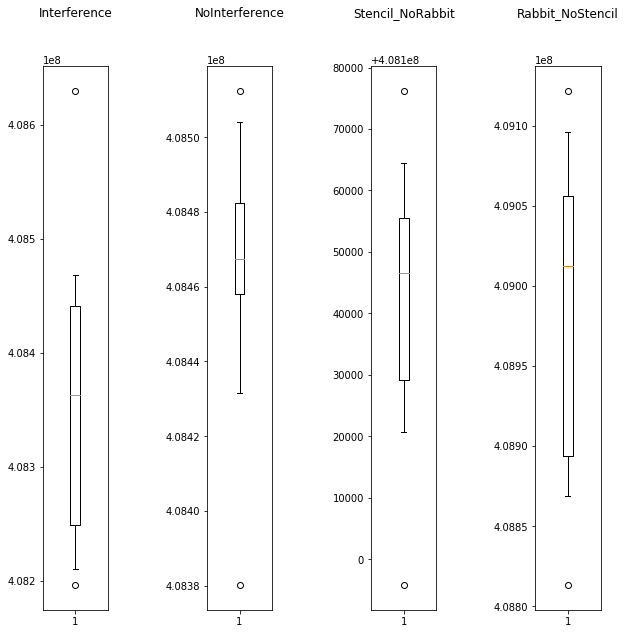

In [5]:
#import matplotlib.cbook as cbook
alpha=.1
labels=['Interference','NoInterference','Stencil_NoRabbit',  'Rabbit_NoStencil']
#stats['A'] = cbook.boxplot_stats(data_list, labels=labels, bootstrap=10000)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))

for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)


fig.subplots_adjust(hspace=0.6,wspace=1.5)

plt.show()


### Bootsrapping on Block Maxima Projection Method 

In [6]:

k=16
iterations=10
blockDataList=[]
for df in [ df_Cori512_Interference,df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference_NoStencil]:
      
    for run in range(0, len(df)):
        blockData=[]
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        #data.append(currentRunTime)
        for i in range(iterations):
            blockprojectedData=analysis.block_maxima_project(currentRun, len(currentData), k, col='workload_max_usec')
            projectedRunTime = sum(blockprojectedData) * (len(currentData) / len(blockprojectedData))
        #print(projectedRunTime)
            blockData.append(projectedRunTime)
    blockData.sort()
    blockDataList.append(blockData)
      

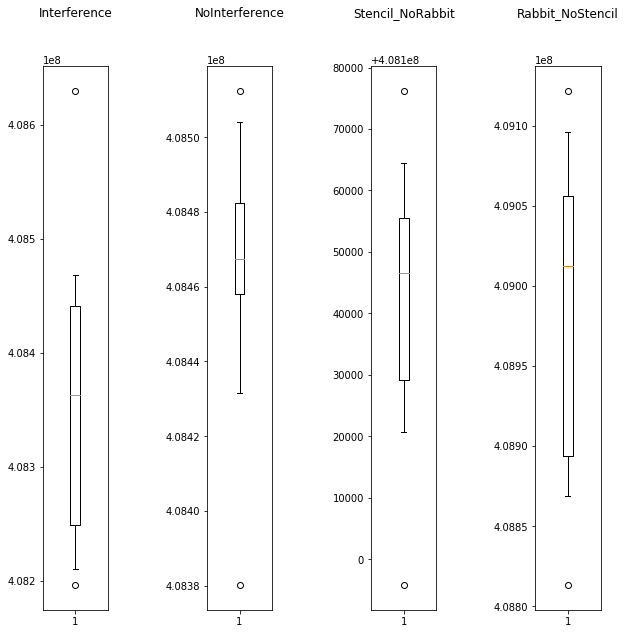

In [7]:
labels=['Interference','NoInterference','Stencil_NoRabbit',  'Rabbit_NoStencil']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))
for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)
fig.subplots_adjust(hspace=0.6,wspace=1.5)
plt.show()


## Box Plots for Experiment 22

In [4]:
k=16
iterations=10

blockDataList=[]
for df in [ df_Cori512_Interference, df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference_NoStencil]:
    for run in range(0, len(df)):
        
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        if eid == 22:
            blockData=[]
            rid = currentRun['expid']
            currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
            currentData = analysis.getData(currentPath)
            currentData = currentData[currentData['rank'] == 0]
            currentRunTime = currentData['interval_max_usec'].sum()
            #data.append(currentRunTime)
            for i in range(iterations):
                resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
                projectedRunTime = sum(resampleprojectedData)
                #print(projectedRunTime)
                blockData.append(projectedRunTime)
            blockData.sort()
            blockDataList.append(blockData)

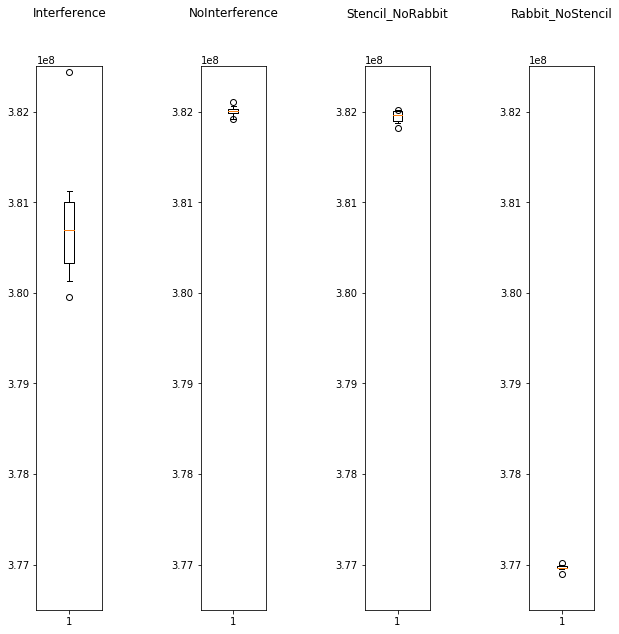

In [9]:
alpha = 0.1

labels=['Interference','NoInterference','Stencil_NoRabbit',  'Rabbit_NoStencil']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))
for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)
    axes[i].set_ylim([3.765*10**8, 3.825*10**8])
fig.subplots_adjust(hspace=0.6,wspace=1.5)
plt.show()

## Box Plots for Experiment 23

In [10]:
k=16
iterations=10

blockDataList=[]
for df in [ df_Cori512_Interference, df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference_NoStencil]:
    for run in range(0, len(df)):
        
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        if eid == 23:
            blockData=[]
            rid = currentRun['expid']
            currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
            currentData = analysis.getData(currentPath)
            currentData = currentData[currentData['rank'] == 0]
            currentRunTime = currentData['interval_max_usec'].sum()
            #data.append(currentRunTime)
            for i in range(iterations):
                resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
                projectedRunTime = sum(resampleprojectedData)
                #print(projectedRunTime)
                blockData.append(projectedRunTime)
            blockData.sort()
            blockDataList.append(blockData)

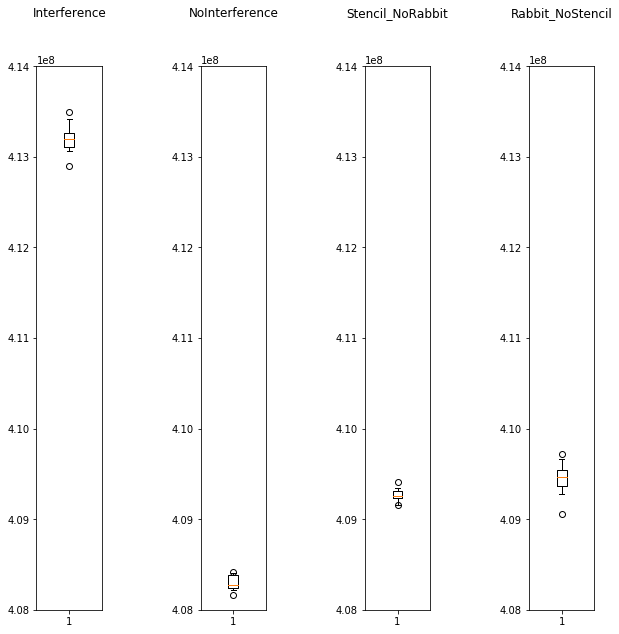

In [11]:
alpha = 0.1

labels=['Interference','NoInterference','Stencil_NoRabbit',  'Rabbit_NoStencil']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))
for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)
    axes[i].set_ylim([4.08*10**8, 4.14*10**8])
fig.subplots_adjust(hspace=0.6,wspace=1.5)
plt.show()

## Box Plots for Experiment 24

In [12]:
k=16
iterations=10

blockDataList=[]
for df in [ df_Cori512_Interference, df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference_NoStencil]:
    for run in range(0, len(df)):
        
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        if eid == 24:
            blockData=[]
            rid = currentRun['expid']
            currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
            currentData = analysis.getData(currentPath)
            currentData = currentData[currentData['rank'] == 0]
            currentRunTime = currentData['interval_max_usec'].sum()
            #data.append(currentRunTime)
            for i in range(iterations):
                resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
                projectedRunTime = sum(resampleprojectedData)
                #print(projectedRunTime)
                blockData.append(projectedRunTime)
            blockData.sort()
            blockDataList.append(blockData)

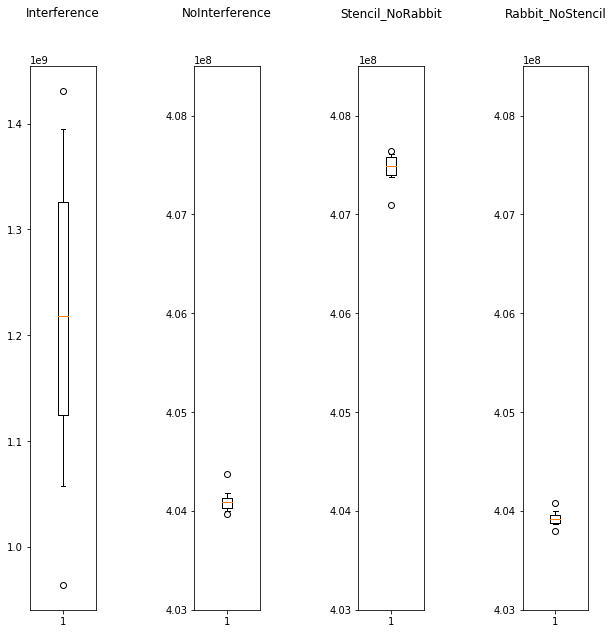

In [13]:
alpha = 0.1

labels=['Interference','NoInterference','Stencil_NoRabbit',  'Rabbit_NoStencil']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))
for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)
    if i > 0:     
        axes[i].set_ylim([4.03*10**8, 4.085*10**8])
fig.subplots_adjust(hspace=0.6,wspace=1.5)
plt.show()

## Box Plots for Experiment 26

In [38]:
k=16
iterations=10

maximaDataList = []
blockDataList=[]
for df in [ df_Cori512_Interference, df_Cori512_NoInterference, df_Cori512_Stencil_NoInterference, df_Cori512_Interference_NoStencil]:
    for run in range(0, len(df)):
        
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        if eid == 26:
            maximaData = []
            blockData=[]
            rid = currentRun['expid']
            currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
            currentData = analysis.getData(currentPath)
            currentData = currentData[currentData['rank'] == 0]
            currentRunTime = currentData['interval_max_usec'].sum()
            #data.append(currentRunTime)
            for i in range(iterations):
                blockprojectedData = analysis.block_maxima_project(currentRun, len(currentData), k, col='workload_max_usec')
                blockprojectedRunTime = sum(blockprojectedData) * (len(currentData) / len(blockprojectedData))
                maximaData.append(blockprojectedRunTime)
                
                resampleprojectedData=analysis.resample_project(currentRun, len(currentData), k, col='workload_max_usec')
                projectedRunTime = sum(resampleprojectedData)
                #print(projectedRunTime)
                blockData.append(projectedRunTime)
            
            maximaData.sort()
            maximaDataList.append(maximaData)
            blockData.sort()
            blockDataList.append(blockData)

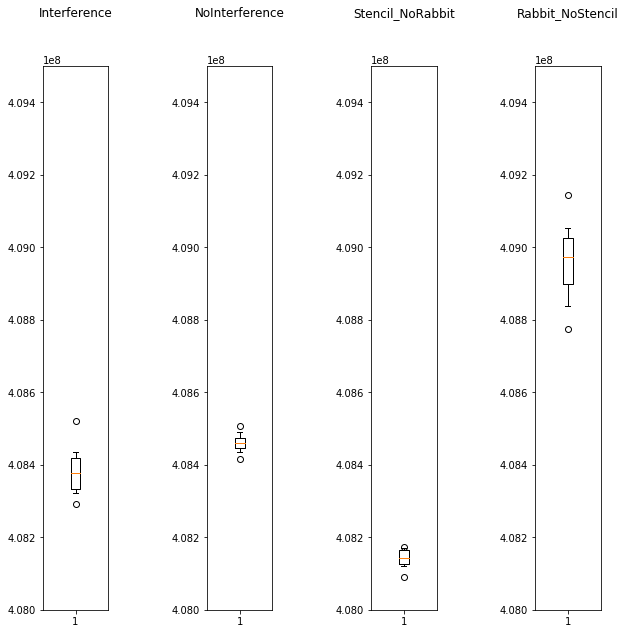

In [15]:
alpha = 0.1

labels=['Interference','NoInterference','Stencil_NoRabbit',  'Rabbit_NoStencil']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))
for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)
    axes[i].set_ylim([4.08*10**8, 4.095*10**8])
fig.subplots_adjust(hspace=0.6,wspace=1.5)
plt.show()

### Comparing confidence interval of resampled combined data and individual experiments' parameters 

## 2000 Rank Data

In [4]:
df_Cori2000 = df_All[(df_All['Experiment'] == 27)]

Cori 2000 Ranks - Stencil
Runtime: 405813486.28499997 Shape: 0.06315333205370423 Loc: 810412.028102918 Scale: 2344.817869481413
Cori 2000 Ranks - Rabbit
Runtime: 405359340.951 Shape: -0.5169906637003799 Loc: 809524.264679821 Scale: 740.4867632962083
Cori 2000 Ranks - Stencil and Rabbit
Runtime: 391966336.89100003 Shape: -0.1688349155290782 Loc: 782266.9583285628 Scale: 2147.211755498142


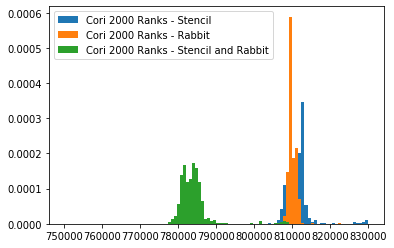

In [31]:
runTimes = []
shapeList = []
locList = []
scaleList = []
count = 0
labels = ["Cori 2000 Ranks - Stencil", "Cori 2000 Ranks - Rabbit", "Cori 2000 Ranks - Stencil and Rabbit"]
for run in range(0, len(df_Cori2000)):
    currentRun = df_Cori2000.iloc[run]
    eid = currentRun['Experiment']
    rid = currentRun['expid']
    currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
    
    currentData = analysis.getData(currentPath)
    currentData = currentData[currentData['rank'] == 0]
    currentRunTime = currentData['interval_max_usec'].sum()
    shape, loc, scale = gevfit.fit(currentData['interval_max_usec'])

    print(labels[count])
    print("Runtime:", currentRunTime, "Shape:", shape, "Loc:", loc, "Scale:", scale)
    # print(gevfit.fit_ci(currentData['interval_max_usec']))

    runTimes.append(currentRunTime)
    shapeList.append(shape)
    locList.append(loc)
    scaleList.append(scale)

    bins = range(750000, 2000, 830000)
    _ = plt.hist(currentData['workload_max_usec'], density=True, label=labels[count], range=[750000, 830000], bins=100)
    count = count + 1

_ = plt.legend()

In [19]:
count = 0
#ndlist=[]
for df in [df_Cori2000]:    
    for run in range(0, len(df)):
        if count == 0:
            title = "Cori 2000 Ranks - Stencil"
        elif count == 1:
            title = "Cori 2000 Ranks - Rabbit"
        elif count == 2:
            title = "Cori 2000 Ranks - Stencil and Rabbit"
    
        print(title)
        
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)

        countData = currentData[currentData['workload_usec'] == currentData['workload_max_usec']].groupby('rank',as_index=False).count()
        rankList = countData['rank'].tolist()
        nodelist=currentData[(currentData['rank'].isin(rankList))]['node'].unique()
        #ndlist.append(nodelist)
        print(rankList, nodelist)
        print("Experiment:", eid)
        print("Contributions by Rank:", end="\t")
        for item in range(0, len(countData)):
            data = countData.iloc[item]
            print(data['uniq_id'], end="\t")
            #print(data['node'],end="\t")
        print()
        count = count + 1
    print()

    

Cori 2000 Ranks - Stencil
[22, 24, 62, 64, 984, 1000, 1023, 1024, 1040, 1064, 1079, 1080, 1982, 1984, 1988] ['nid01560' 'nid01561' 'nid01570' 'nid13055' 'nid00786' 'nid00829'
 'nid00830' 'nid01559']
Experiment: 27
Contributions by Rank:	7	1	1	3	5	193	9	89	99	8	38	22	14	10	1	
Cori 2000 Ranks - Rabbit
[26, 28, 1046, 1048, 1052] ['nid01561' 'nid00786']
Experiment: 27
Contributions by Rank:	14	4	142	339	1	
Cori 2000 Ranks - Stencil and Rabbit
[1476, 1492, 1623, 1637, 1639, 1640, 1656, 1661, 1676, 1677, 1679, 1696, 1717, 1719, 1736, 1768] ['nid02016' 'nid02152' 'nid02153' 'nid02182' 'nid02183' 'nid02188'
 'nid02189']
Experiment: 27
Contributions by Rank:	1	1	1	6	47	341	6	1	1	3	74	8	2	3	4	1	



## All Cori Data Runtimes (With 500 Iterations, so Experiments 19-27, Excluding Exp 21)

In [6]:
# Get only Cori 512 Rank data
df_Cori_All = df_All[(df_All['Experiment'] == 19) | (df_All['Experiment'] == 20) | (df_All['Experiment'] == 22) | (df_All['Experiment'] == 23) | (df_All['Experiment'] == 24) | (df_All['Experiment'] == 25) | (df_All['Experiment'] == 26) | (df_All['Experiment'] == 27)]

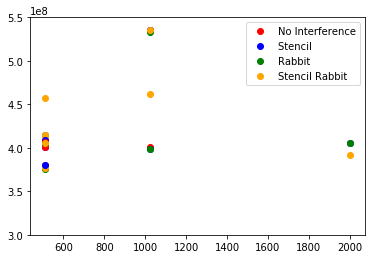

In [7]:
colorlist = ['red', 'blue', 'green', 'orange']

for df in [df_Cori_All]:
    for run in range(0, len(df)):
        label = ''
        currentRun = df_Cori_All.iloc[run]
        eid = currentRun['Experiment']
        ranks = currentRun['processors']
        stencil = currentRun['stencil_size']
        rab_work = currentRun['rabbit_workload']
        iterations = currentRun['iterations']
        if int(stencil) > 0:
            label = label + 'Stencil '
        if int(rab_work) > 0:
            label = label + 'Rabbit '
            
        if label == '':
            label = 'No Interference'
            val = 0
        elif label == 'Stencil ':
            val = 1
        elif label == "Rabbit ":
            val = 2
        else:
            val = 3
        
        #print(label, val, ranks, "Ranks", iterations, "Iterations")
        
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'

        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        shape, loc, scale = gevfit.fit(currentData['interval_max_usec'])

        #print("Runtime:", currentRunTime, "Shape:", shape, "Loc:", loc, "Scale:", scale)
        plt.plot( ranks, currentRunTime, 'o', color=colorlist[val], label=label)
        
plt.ylim(3*10**8, 5.5*10**8)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

## Combined Maximum Data and Box Plot

- All 512 Rank Data (Experiments 22, 23, 24, and 26) were combined and Resample Projection was used on the aggregate data to estimate the confidence interval of projections of to larger scales.

- Results look promising, but we might want to remove experiment 24 since it was such an outlier and it looks like it is really driving the results

In [5]:
# Get only Cori 512 Rank data
df_Cori512 = df_All[(df_All['Experiment'] == 22) | (df_All['Experiment'] == 23) | (df_All['Experiment'] == 24) | (df_All['Experiment'] == 26)]

# Remove Experiment 24
#df_Cori512 = df_All[(df_All['Experiment'] == 22) | (df_All['Experiment'] == 23) | (df_All['Experiment'] == 26)]

count = 0
for df in [df_Cori512]:
    for run in range(0, len(df)):
        label = ''
        
        currentRun = df_Cori512.iloc[run]
        eid = currentRun['Experiment']
        ranks = currentRun['processors']
        stencil = currentRun['stencil_size']
        rab_work = currentRun['rabbit_workload']
        iterations = currentRun['iterations']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        
        if count == 0:
            NoInterferenceAggregate = pd.DataFrame(columns=currentData.columns)
            StencilAggregate = pd.DataFrame(columns=currentData.columns)
            RabbitAggregate = pd.DataFrame(columns=currentData.columns)
            InterferenceAggregate = pd.DataFrame(columns=currentData.columns)
        
        if int(stencil) > 0:
            label = label + 'Stencil '
        if int(rab_work) > 0:
            label = label + 'Rabbit '
            
        if label == '':
            NoInterferenceAggregate = NoInterferenceAggregate.append(currentData)
        elif label == 'Stencil ':
            StencilAggregate = StencilAggregate.append(currentData)
        elif label == "Rabbit ":
            RabbitAggregate = RabbitAggregate.append(currentData)
        else:
            InterferenceAggregate = InterferenceAggregate.append(currentData)
        count = count + 1

Data:  Interference 
 Shape: 0.14499448770951465 Loc: 453972225.0611522 scale: 21693221.48484686 
CI: [(0.02271311766856308, 0.29611788868107136), (449632365.81153375, 458986586.2303171), (18612620.85000713, 24745069.878109884)]
Data:  NoInterference 
 Shape: 0.2424688080734774 Loc: 406561321.7080212 scale: 51505.40000210605 
CI: [(0.10313447196952837, 0.40572286804637386), (406550057.2141896, 406572972.12579167), (44521.6010448861, 57677.72219820189)]
Data:  Stencil_NoRabbit 
 Shape: 0.32019816594771294 Loc: 407370456.5055961 scale: 54840.22591110977 
CI: [(0.15037667205906297, 0.5252437998990971), (407358392.4004073, 407382209.0534274), (43581.169354289304, 65904.70784008857)]
Data:  Rabbit_NoStencil 
 Shape: 0.22044175377017275 Loc: 406713647.6984297 scale: 57387.32656730623 
CI: [(0.06868752393277626, 0.3929993661481612), (406701903.85005623, 406727612.5185437), (48562.55262055855, 65039.593401231155)]


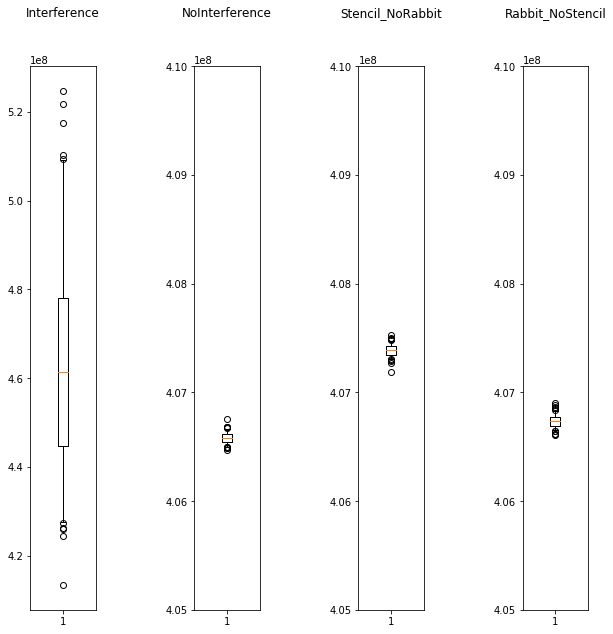

In [8]:
from sklearn.utils import resample

# Needed to Correct Project Runtime from 2000 iterations to the original 500 itera
factor = 4 # 4 Identical Experiments, each has 500 iterations (total 2000 iterations)
k = 4
j=0
iterations = 100
labels=['Interference', 'NoInterference', 'Stencil_NoRabbit',  'Rabbit_NoStencil']
blockDataList = []
for df in [InterferenceAggregate, NoInterferenceAggregate, StencilAggregate, RabbitAggregate, ]:
    expList = []
    for i in range(iterations):
        data = analysis.resample_project(df, len(df), k, col='workload_max_usec')
        projectedRunTime = sum(data) / factor
        #print(projectedRunTime)
        expList.append(projectedRunTime)
    shape, loc, scale= gevfit.fit(expList) 
    fit, ci= gevfit.fit_ci(expList)
    print('Data: ',labels[j], '\n Shape:', shape, 'Loc:', loc, 'scale:', scale,'\nCI:', ci)
    j=j+1
    blockDataList.append(expList)

    
alpha = 0.1

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))
for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)
    if i > 0:
        axes[i].set_ylim([4.05*10**8, 4.10*10**8])
fig.subplots_adjust(hspace=0.6,wspace=1.5)
plt.show()

Interference
No Interference
Stencil
Rabbit
Interference
No Interference
Stencil


(300000000, 600000000)

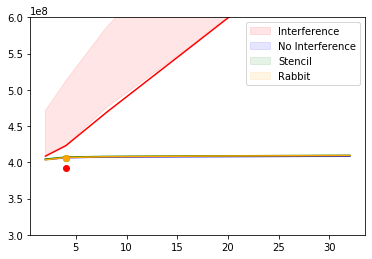

In [6]:
from sklearn.utils import resample

# Needed to Correct Project Runtime from 2000 iterations to the original 500 iterations
factor = 4 # 4 Identical Experiments, each has 500 iterations (total 2000 iterations)
kvals = [2, 4, 8, 16, 32]
iterations = 50
cutoff = 2 # ~90% confidence interval with iterations = 100

fig, ax = plt.subplots()
count = 0
colorlist = ['red', 'blue', 'green', 'orange']
labels = ['Interference', 'No Interference', 'Stencil', 'Rabbit']
for df in [InterferenceAggregate, NoInterferenceAggregate, StencilAggregate, RabbitAggregate]:    
    print(labels[count])
    
    lowerBound = []
    median = []
    upperBound = []
    for k in kvals:   
        expList = []
        for i in range(iterations):
            data = analysis.resample_project(df, len(df), k, col='workload_max_usec')
            projectedRunTime = sum(data) / factor
            #print(projectedRunTime)
            expList.append(projectedRunTime)
        expList.sort()
        
        lowerBound.append(expList[cutoff])
        median.append(expList[int(cutoff / 2)])
        upperBound.append(expList[-cutoff])
        
    _ = ax.plot(kvals, median, color=colorlist[count], label=labels[count])
    _ = ax.fill_between(kvals, lowerBound, upperBound, color=colorlist[count], alpha=.1, label=labels[count])
    count = count + 1


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
_ = plt.legend(by_label.values(), by_label.keys())

count = 0
colorlist = ['green', 'orange', 'red']
for run in range(0, len(df_Cori2000)):
    currentRun = df_Cori2000.iloc[run]
    eid = currentRun['Experiment']
    rid = currentRun['expid']
    currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
    
    currentData = analysis.getData(currentPath)
    currentData = currentData[currentData['rank'] == 0]
    currentRunTime = currentData['interval_max_usec'].sum()

    print(labels[count])

    _ = ax.plot(4, currentRunTime, 'o', color=colorlist[count])
    count = count + 1

ax.set_ylim([3*10**8, 6*10**8])

Data:  df_Cori512_exp22 
 Shape: -0.01986915865129682 Loc: 376062164.5989663 scale: 26233.105470384275 
CI: [(-0.4067472232664789, 0.8573041292381747), (376048548.20542717, 376084695.5362969), (9914.498383835149, 43653.54488067099)]
Data:  df_Cori512_exp23 
 Shape: 0.48796014126337756 Loc: 407987019.7832484 scale: 97082.00888689506 
CI: [(-0.18097107943924642, 1.5231774577641222), (407917560.7120401, 408070980.1674528), (43390.89502279433, 108690.77755556157)]
Data:  df_Cori512_exp24 
 Shape: 0.4060183991677906 Loc: 403902101.21372503 scale: 211024.95096215024 
CI: [(-0.3859932432537682, 1.2804551903673713), (403749039.7196013, 404066114.2883452), (69465.11511457675, 239179.90081204814)]
Data:  df_Cori512_exp26 
 Shape: 0.6373290432650839 Loc: 406743933.60413116 scale: 129954.72067386637 
CI: [(-0.11702033156898073, 1.5389970450752315), (406645732.8142892, 406842460.7086129), (55746.24804931809, 142472.9323973832)]


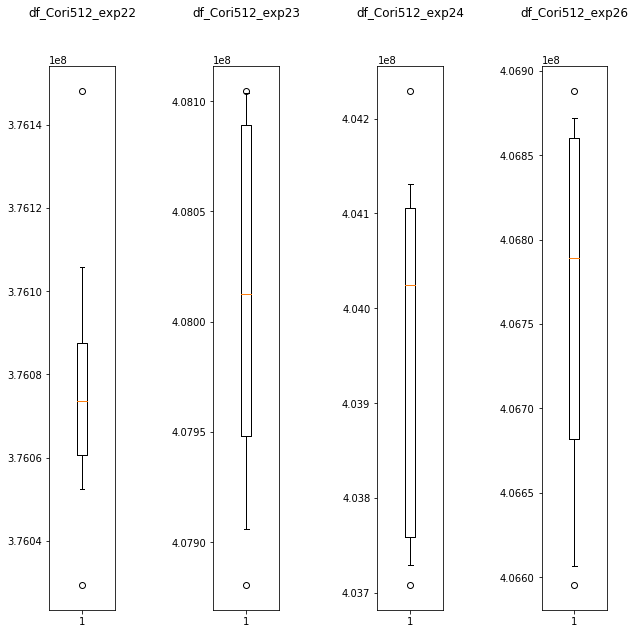

In [8]:
k = 4
j=0
iterations = 10
labels=['df_Cori512_exp22', 'df_Cori512_exp23', 'df_Cori512_exp24',  'df_Cori512_exp26']
blockDataList = []
for df in [df_Cori512_exp22, df_Cori512_exp23, df_Cori512_exp24, df_Cori512_exp26 ]:
    expList = []
    for i in range(iterations):
        data = analysis.resample_project(df, len(df), k, col='workload_max_usec')
        projectedRunTime = sum(data) 
        #print(projectedRunTime)
        expList.append(projectedRunTime)
    shape, loc, scale= gevfit.fit(expList) 
    fit, ci= gevfit.fit_ci(expList)
    print('Data: ',labels[j], '\n Shape:', shape, 'Loc:', loc, 'scale:', scale,'\nCI:', ci)
    j=j+1
    blockDataList.append(expList)

    
alpha = 0.1

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))
for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)
    #axes[i].set_ylim([4.05*10**8, 4.10*10**8])
fig.subplots_adjust(hspace=0.6,wspace=1.5)
plt.show()
    